# Image Classification with a Convolutional Neural Network

Following the *Image Classification* tenserflow tutorial.

With my own notes in the markdown and code comments.

### Load Libraries and Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL #Python Imaging Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#get dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 8s 0us/step


The directory is structured as follows:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```



In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


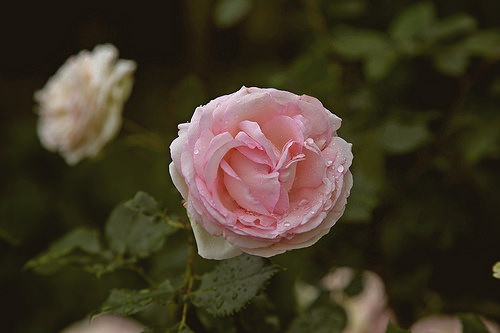

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[4]))